In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
os.environ['MERCONT_HOME'] = '/Users/kadofong/work/projects/merian/meriancontinuum/'

import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import cosmology,coordinates, table
from astropy import units as u
from astropy.io import fits

from ekfphys import observer, calibrations
from ekfstats import functions, sampling
from ekfplot import plot as ek
from ekfplot import colors as ec

from agrias import photometry,utils


from meriancontinuum import fitting_utils

import reader

cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [7]:
merian = table.Table(fits.getdata('../local_data/inputs/Merian_DR1_photoz_EAZY_v1.2.fits',1))
mcoords = coordinates.SkyCoord( merian['coord_ra_Merian'], merian['coord_dec_Merian'], unit='deg')
mcat = reader.merianselect(merian, av=0.3)

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


In [8]:
emission_correction = fitting_utils.correct_N2_S3(
    mcat['z_phot'],
    mcat['logmass_gaap1p0']
)**-1

In [9]:
from ekfparse import query

In [10]:
load_from_pickle=True
if load_from_pickle:
    with open('../local_data/output/dustengine.pickle', 'rb') as f:
        dusteng = pickle.load(f)
else:
    dusteng = query.DustEngine()
    

In [11]:
direct_geav = mcat.apply(lambda row: dusteng.get_SandFAV(row['RA'], row['DEC']),axis=1)

In [12]:
if not load_from_pickle:    
    with open('../local_data/output/dustengine.pickle', 'wb') as f:
        pickle.dump(dusteng, f)

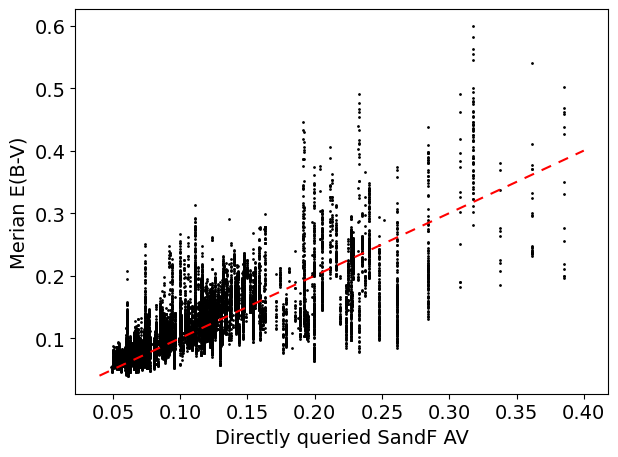

In [13]:
xs = np.linspace(0.04,0.4,10)
plt.scatter(direct_geav, mcat['ebv_Merian']*3.01, s=1,color='k')
plt.plot(xs,xs, color='r', dashes=[5,4])
plt.xlabel('Directly queried SandF AV')
plt.ylabel('Merian E(B-V)')
plt.tight_layout()
plt.savefig('/Users/kadofong/Desktop/GE_correction_comparison.png')

In [14]:
ge_arr = photometry.uvopt_gecorrection(mcat, av=direct_geav)

In [15]:
restwl = np.array([1548.85, 2303.37, 7080.])

dust_corr = np.zeros((len(emission_correction),3))
for idx,av in enumerate(mcat['AV']):
    if hasattr(av,'mask'):
        dust_corr[idx] = np.NaN
    else:
        dust_corr[idx] = observer.extinction_correction ( restwl, av, RV=4.05)[0].data


In [16]:
apercorr = mcat['i_cModelFlux_Merian'] / mcat['i_gaap1p0Flux_Merian']

In [17]:
packaged = {}
z_col = 'z_phot'

extendedness = mcat['i_cModelFlux_Merian'] / mcat[utils.photcols['i']]
inband_cat = (extendedness>1.3)

merian_cat = table.Table.from_pandas(mcat[inband_cat].reset_index())

haflux, u_haflux, halum, u_halum = photometry.mbestimate_halpha(
    merian_cat[utils.photcols['N708']],
    merian_cat[utils.photcols['r']],
    merian_cat[utils.photcols['i']],
    merian_cat[z_col],
    merian_cat[utils.u_photcols['N708']],
    merian_cat[utils.u_photcols['r']],
    merian_cat[utils.u_photcols['i']],    
    apercorr=apercorr[inband_cat].values,
    ge_correction=ge_arr[inband_cat,2],
    ex_correction=dust_corr[inband_cat,2],
    ns_correction=emission_correction[inband_cat],
    do_aperturecorrection=True,
    do_gecorrection=True,
    do_extinctioncorrection=True,
    do_linecorrection=True,
    specflux_unit=u.nJy
)


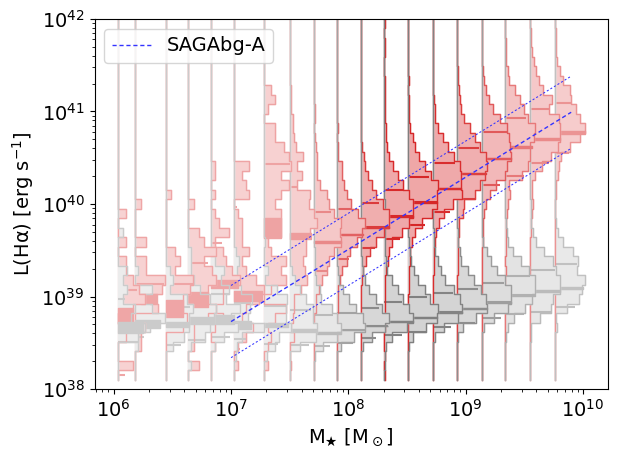

In [18]:
xd = 10.**mcat['logmass_gaap1p0'] * apercorr
yd = halum.value 

yd = np.where(yd==0, np.NaN,yd)
u_yd = u_halum.value
xd,yd,u_yd = functions.fmasker(xd,yd,u_yd)


xbins = np.logspace(6.,10.,20)
ybins = np.logspace(38.,42.,40)
_=ek.histstack(
    xd,
    yd,
    xbins=xbins,
    ybins=ybins,
    edgecolor='tab:red',
    quantilecolor='tab:red',
    facecolor=ec.ColorBase('tab:red').modulate(0.3).base,
    label='Merian'
)
_=ek.histstack(
    xd,
    u_yd,
    xbins=xbins,
    ybins=ybins,
    edgecolor=ec.ColorBase('k').modulate(0.5).base,
    quantilecolor=ec.ColorBase('k').modulate(0.5).base,
)

ms = np.linspace(7., 9.9,30)
saga_params = [0.78, -1.36, 0.39]
plt.plot(
    10.**ms,
    calibrations.SFR2LHa(10.**(saga_params[0]*(ms-8.5) + saga_params[1])),
    dashes=[3,2],
    lw=1,
    color=ec.ColorBase('b').modulate(0.1).base,
    label='SAGAbg-A'
)
for sign in [-1.,1.]:
    plt.plot(
        10.**ms,
        calibrations.SFR2LHa(10.**(saga_params[0]*(ms-8.5) + saga_params[1] + sign*saga_params[2])),
        dashes=[2,2],
        lw=0.75,
        color=ec.ColorBase('b').modulate(0.1).base,
    )    

ek.loglog()
plt.ylim(ybins.min(),ybins.max())
plt.legend(loc='upper left')
plt.xlabel(ek.common_labels['mstar'])
plt.ylabel(ek.common_labels['halum'])

plt.tight_layout ()
plt.savefig('../../../sfr_calibrators/figures/data_validation/Merian_SFS.png')

In [19]:
saga_expectation = calibrations.SFR2LHa(10.**(saga_params[0]*(np.log10(xd)-8.5) + saga_params[1]))

In [31]:
thresh = 1.5
sb_cutoff = calibrations.SFR2LHa(10.**(saga_params[0]*(np.log10(xd)-8.5) + saga_params[1] + thresh*saga_params[2]))
mass_cutoff = xd > 4e7
mbcolor = -2.5*np.log10(mcat[utils.photcols['N708']]/mcat[utils.photcols['i']])
is_physicalcolor = abs(mbcolor) < 1.

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_61006/3979508972.py:1: RuntimeWarning: invalid value encountered in log10
  ek.hist ( (np.log10(yd) - np.log10(saga_expectation))[mass_cutoff], bintype='linear', bins=80, binalpha=0.001 )


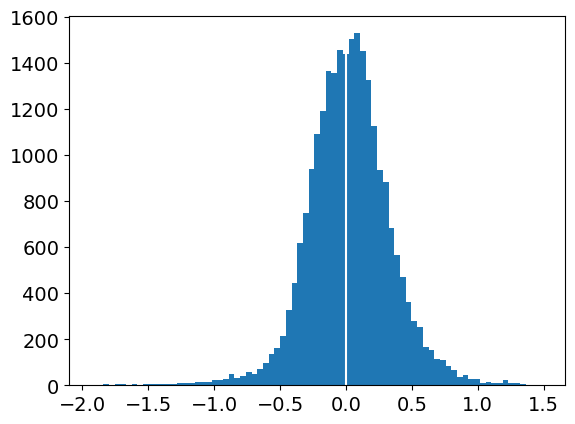

In [32]:
ek.hist ( (np.log10(yd) - np.log10(saga_expectation))[mass_cutoff], bintype='linear', bins=80, binalpha=0.001 )
plt.axvline(0., color='w')

In [33]:
is_sb = (yd > sb_cutoff)&(mass_cutoff)&is_physicalcolor
print(is_sb.sum())

879


In [34]:
mcat.loc[is_sb].reset_index().rename({'index':"Name"},axis=1)[["Name",'RA','DEC']].to_csv('~/Desktop/Merian_starbursts.csv', index=False)

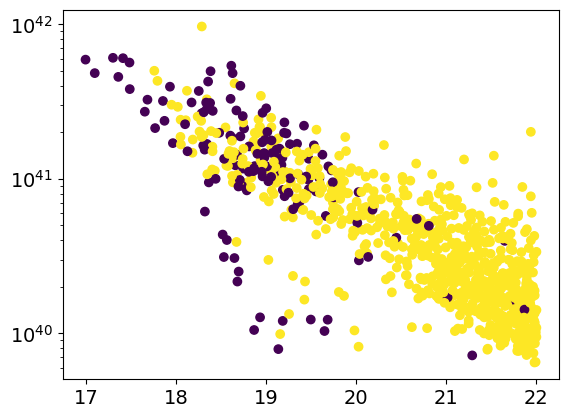

In [35]:
plt.scatter(
    -2.5*np.log10(mcat.loc[is_sb, utils.photcols['N708']]) + 31.4,
    yd[is_sb],
    c=np.isnan(mcat.loc[is_sb,'z_spec'])
)
plt.yscale('log')

In [36]:
mid = mcat.index[is_sb][13]

In [37]:
lha_df = pd.read_csv('../local_data/output/lha_df.csv', index_col=0)
lha_df = lha_df.reindex(mcat.index)
print(lha_df.dropna().shape)

(14138, 4)


/Users/kadofong/work/ekfutils/ekfplot/ekfplot/plot.py:271: RuntimeWarning: invalid value encountered in log10
  'log':lambda input: np.logspace ( *np.quantile(np.log10(input)[np.isfinite(np.log10(input))],
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


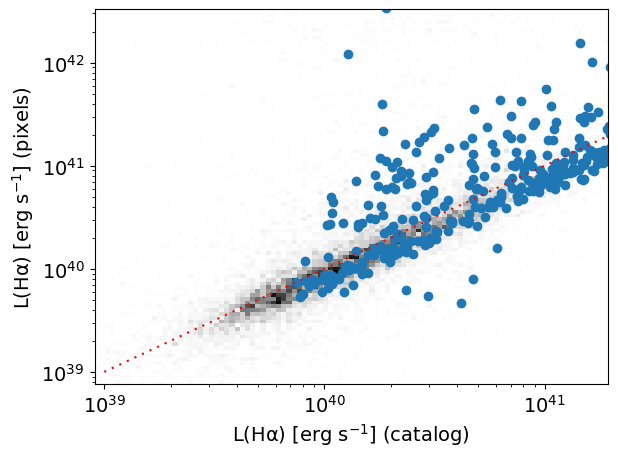

In [38]:
ek.hist2d(
    halum.value,
    lha_df.loc[:, 'LHa']*1e40,
    bins=100,
    xscale='log',
    yscale='log'
)
plt.scatter(
    halum[is_sb],
    lha_df.loc[is_sb, 'LHa']*1e40,
    label='starbursts'
)
xs = np.logspace(39.,43.)
plt.plot(xs,xs,color='r', dashes=[1,3])
ek.loglog()
plt.xlabel(ek.common_labels['halum'] + ' (catalog)' )
plt.ylabel(ek.common_labels['halum'] + ' (pixels)' )
plt.tight_layout ()
plt.savefig('/Users/kadofong/Desktop/lha_starbursts.png')